In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold,cross_val_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
from tqdm import tqdm_notebook as tqdm

import gc
gc.enable()

In [2]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    print (categorical_columns)
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

print('Read data and test')
data = pd.read_csv('./input/application_train.csv')
test = pd.read_csv('./input/application_test.csv')
print('data test Shapes : ', data.shape, test.shape)

y = data['TARGET']
del data['TARGET']
gc.collect()
all_data = pd.concat((data, test)).reset_index(drop=True)

inc_by_org = all_data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
all_data['NEW_INC_BY_ORG'] = all_data['ORGANIZATION_TYPE'].map(inc_by_org)
print('all_data Shape : ', all_data.shape)

for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    all_data[bin_feature], uniques = pd.factorize(all_data[bin_feature])
all_data, cat_cols = one_hot_encoder(all_data)
print('all_data Shape : ', all_data.shape)
# Some simple new features (percentages)
#all_data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
n_data = data.shape[0]

all_data['INCOME_DAYS_PERC'] = all_data['AMT_INCOME_TOTAL'] / all_data['DAYS_BIRTH']
all_data['DAYS_EMPLOYED_PERC'] = all_data['DAYS_EMPLOYED'] / all_data['DAYS_BIRTH']
all_data['INCOME_CREDIT_PERC'] = all_data['AMT_INCOME_TOTAL'] / all_data['AMT_CREDIT']
all_data['INCOME_PER_PERSON'] = all_data['AMT_INCOME_TOTAL'] / all_data['CNT_FAM_MEMBERS']
all_data['ANNUITY_INCOME_PERC'] = all_data['AMT_ANNUITY'] / all_data['AMT_INCOME_TOTAL']
all_data['PAYMENT_RATE'] = all_data['AMT_CREDIT'] / all_data['AMT_ANNUITY']
print('all_data Shape : ', all_data.shape)
del data,test
gc.collect()

bureau = pd.read_csv('./input/bureau.csv')
buro_bal = pd.read_csv('./input/bureau_balance.csv')
print('bureau  buro_bal Shape : ', bureau.shape,buro_bal.shape)
buro_bal, bb_cat = one_hot_encoder(buro_bal)
bureau, bureau_cat = one_hot_encoder(bureau)
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max','mean']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
    bb_agg = buro_bal.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg['BB_COUNT'] = buro_bal.groupby('SK_ID_BUREAU').size()
print('bb_agg Shape : ', bb_agg.shape)
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
print('bureau Shape : ', bureau.shape)
del buro_bal,bb_agg
gc.collect()
bureau['PEC_ANNUITY_DEBT'] = bureau['AMT_ANNUITY']/bureau['AMT_CREDIT_SUM_DEBT']
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'CNT_CREDIT_PROLONG': ['sum','mean'],
    'PEC_ANNUITY_DEBT':['min','max','mean'],
    'AMT_CREDIT_SUM': ['max','mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max','mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'DAYS_CREDIT_UPDATE': ['min','max','mean'],
    'AMT_ANNUITY': ['max', 'mean'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_MEAN': ['mean'],
    'BB_COUNT': ['mean', 'sum']
}
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
bureau_agg = bureau.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
bureau_agg['BURO_COUNT'] = bureau.groupby('SK_ID_CURR').size()
bureau_agg['BURO_MAX_OVERDUE_DEBT'] = bureau_agg['BURO_AMT_CREDIT_MAX_OVERDUE_MEAN']/bureau_agg['BURO_AMT_CREDIT_SUM_DEBT_MEAN']
print('bureau_agg Shape : ', bureau_agg.shape)

active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
active_agg['ACT_COUNT'] = active.groupby('SK_ID_CURR').size()
bureau_agg = bureau_agg.reset_index().join(active_agg, how='left', on='SK_ID_CURR')
print('bureau_agg Shape : ', bureau_agg.shape)
del active, active_agg
gc.collect()

closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(dict({'DAYS_ENDDATE_FACT': ['min','max','mean']},**num_aggregations))
closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
closed_agg['CLS_COUNT'] = closed.groupby('SK_ID_CURR').size()
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
print('bureau_agg Shape : ', bureau_agg.shape)
del closed, closed_agg, bureau
gc.collect()

all_data = all_data.merge(bureau_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del bureau_agg
gc.collect()

prev = pd.read_csv('./input/previous_application.csv')
print('prev Shape : ', prev.shape)
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min','max', 'mean'],
    'AMT_APPLICATION': ['min','max', 'mean'],
    'AMT_CREDIT': ['min','max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'SELLERPLACE_AREA': ['min', 'max', 'mean'],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['min', 'max', 'mean'],
    'DAYS_TERMINATION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum']
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
prev_agg['PREV_COUNT'] = prev.groupby('SK_ID_CURR').size()
print('prev_agg Shape : ', prev_agg.shape)
# Previous Applications: Approved Applications - only numerical features

ap_num_aggregations = {
        'AMT_ANNUITY': ['min','max', 'mean'],
        'AMT_APPLICATION': ['min','max', 'mean'],
        'AMT_CREDIT': ['min','max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'SELLERPLACE_AREA': ['min', 'max', 'mean'],
        'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
        'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE': ['min', 'max', 'mean'],
        'DAYS_TERMINATION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'NEW_PA_AMT_UNREPAID':['min','max','mean', 'sum']
    }
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved['NEW_PA_AMT_UNREPAID'] = approved[approved['DAYS_LAST_DUE_1ST_VERSION'] > 0]\
    ['DAYS_LAST_DUE_1ST_VERSION']/30*(approved[approved['DAYS_LAST_DUE_1ST_VERSION'] > 0]['AMT_ANNUITY'])
approved_agg = approved.groupby('SK_ID_CURR').agg(ap_num_aggregations)
approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
approved_agg['APR_COUNT'] = approved.groupby('SK_ID_CURR').size()
prev_agg = prev_agg.reset_index().join(approved_agg, how='left', on='SK_ID_CURR')
print('prev_agg Shape : ', prev_agg.shape)
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
refused_agg['REF_COUNT'] = refused.groupby('SK_ID_CURR').size()
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
print('prev_agg Shape : ', prev_agg.shape)
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

all_data = all_data.merge(prev_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del prev_agg
gc.collect()

pos = pd.read_csv('./input/POS_CASH_balance.csv')
print('pos Shape : ', pos.shape)
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['min','max', 'mean'],
    'CNT_INSTALMENT': ['sum', 'mean'],
    'SK_DPD': ['sum','max','min','mean','size'],
    'SK_DPD_DEF': ['sum','max', 'min','mean','size']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
print('pos_agg Shape : ', pos_agg.shape)
del pos
gc.collect()

all_data = all_data.join(pos_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del pos_agg
gc.collect()

ins = pd.read_csv('./input/installments_payments.csv')
print('ins Shape : ', ins.shape)
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['NEW_IP_DPD_RATIO'] = ins['DAYS_ENTRY_PAYMENT'] / ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['NEW_IP_DBD_RATIO'] = ins['DAYS_INSTALMENT'] / ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max','mean', 'sum'],
    'NEW_IP_DPD_RATIO':['max', 'mean','min'],
    'NEW_IP_DBD_RATIO':['max', 'mean','min'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
print('ins_agg Shape : ', ins_agg.shape)
del ins
gc.collect()

all_data = all_data.join(ins_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del ins_agg
gc.collect()

cc = pd.read_csv('./input/credit_card_balance.csv')
print('cc Shape : ', cc.shape)
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# Features: Perform aggregations
num_aggregations = {
    'MONTHS_BALANCE': ['min','max', 'mean'],
    'AMT_BALANCE': ['min','max', 'mean','sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['min','max', 'mean','sum','var'],
    'AMT_DRAWINGS_ATM_CURRENT': ['min','max', 'mean','sum'],
    'AMT_DRAWINGS_CURRENT': ['min','max', 'mean','sum'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['min','max', 'mean','sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['min','max', 'mean','sum'],
    'AMT_INST_MIN_REGULARITY': ['min','max', 'mean','sum','var'],
    'AMT_PAYMENT_CURRENT':['min','max', 'mean','sum'],
    'AMT_PAYMENT_TOTAL_CURRENT':['min','max', 'mean','sum'],
    'AMT_RECEIVABLE_PRINCIPAL':['min','max', 'mean','sum','var'],
    'AMT_RECIVABLE':['min','max', 'mean','sum','var'],
    'AMT_TOTAL_RECEIVABLE':['min','max', 'mean','sum','var'],
    'CNT_DRAWINGS_ATM_CURRENT':['mean','sum'],
    'CNT_DRAWINGS_CURRENT':['mean','sum'],
    'CNT_DRAWINGS_OTHER_CURRENT':['mean','sum'],
    'CNT_DRAWINGS_POS_CURRENT':['mean','sum'],
    'CNT_INSTALMENT_MATURE_CUM':['mean','sum'],
    'SK_DPD':['max', 'mean', 'sum'],
    'SK_DPD_DEF':['max', 'mean', 'sum']
}
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
# General aggregations
cc_agg = cc.groupby('SK_ID_CURR').agg(dict(num_aggregations,**cat_aggregations))
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

#cc_agg['INSTALLMENTS_PER_LOAN'] = cc_agg['CNT_INSTALMENT_MATURE_CUM_SUM'] / cc_agg['CC_COUNT']
del cc
print('cc_agg Shape : ', cc_agg.shape)
gc.collect()

all_data = all_data.join(cc_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del cc_agg
gc.collect()

Read data and test
('data test Shapes : ', (307511, 122), (48744, 121))
('all_data Shape : ', (356255, 122))
['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
('all_data Shape : ', (356255, 255))
('all_data Shape : ', (356255, 261))
('bureau  buro_bal Shape : ', (1716428, 17), (27299925, 3))
['STATUS']
['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
('bb_agg Shape : ', (817395, 13))
('bureau Shape : ', (1716428, 52))
('bureau_agg Shape : ', (305811, 71))
('bureau_agg Shape : ', (305811, 107))
('bureau_agg Shape : ', (305811, 145))
('all_data Shape : ', (356255, 405))
('prev Shape : ', (1670214, 37))
['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', '

7

In [3]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

missing_data

drop_col = missing_data[missing_data['Missing Ratio']==100]
missing_data = missing_data[missing_data['Missing Ratio']<100]

all_data.drop(drop_col.index.values,1,inplace=True)

data = all_data[:n_data]
test = all_data[n_data:]
#del avg_buro, avg_prev,avg_pos,avg_cc_bal,avg_inst
del all_data
gc.collect()
print data.shape
print test.shape

exclude_fea = []
exclude_fea.append('SK_ID_CURR') 
exclude_fea

(307511, 830)
(48744, 830)


['SK_ID_CURR']

In [6]:
folds = KFold(n_splits=5, shuffle=True, random_state=1700)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in data.columns if f not in exclude_fea]

In [40]:
len(feats)
seeds = [1500,1600,1700,1800,1900]

In [5]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=31,
        colsample_bytree=0.9338690,
        subsample=0.97291513,
        max_depth=8,
        reg_alpha=0.06663684,
        reg_lambda=0.0988343,
        min_split_gain=0.07916152,
        min_child_weight=82.8850799,
        random_state=1700,
    )
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.753077	valid_1's auc: 0.739431
[200]	training's auc: 0.782726	valid_1's auc: 0.762276
[300]	training's auc: 0.801927	valid_1's auc: 0.775639
[400]	training's auc: 0.813935	valid_1's auc: 0.782417
[500]	training's auc: 0.822775	valid_1's auc: 0.785507
[600]	training's auc: 0.83018	valid_1's auc: 0.787615
[700]	training's auc: 0.836294	valid_1's auc: 0.788811
[800]	training's auc: 0.841926	valid_1's auc: 0.789645
[900]	training's auc: 0.847108	valid_1's auc: 0.790455
[1000]	training's auc: 0.85178	valid_1's auc: 0.790868
[1100]	training's auc: 0.856158	valid_1's auc: 0.791541
[1200]	training's auc: 0.860392	valid_1's auc: 0.79208
[1300]	training's auc: 0.864606	valid_1's auc: 0.79237
[1400]	training's auc: 0.868635	valid_1's auc: 0.792427
[1500]	training's auc: 0.872363	valid_1's auc: 0.792672
[1600]	training's auc: 0.876097	valid_1's auc: 0.792844
[1700]	training's auc: 0.87964	valid_1's auc: 0.792886

KeyboardInterrupt: 

In [7]:
test['TARGET'] = sub_preds

test[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)

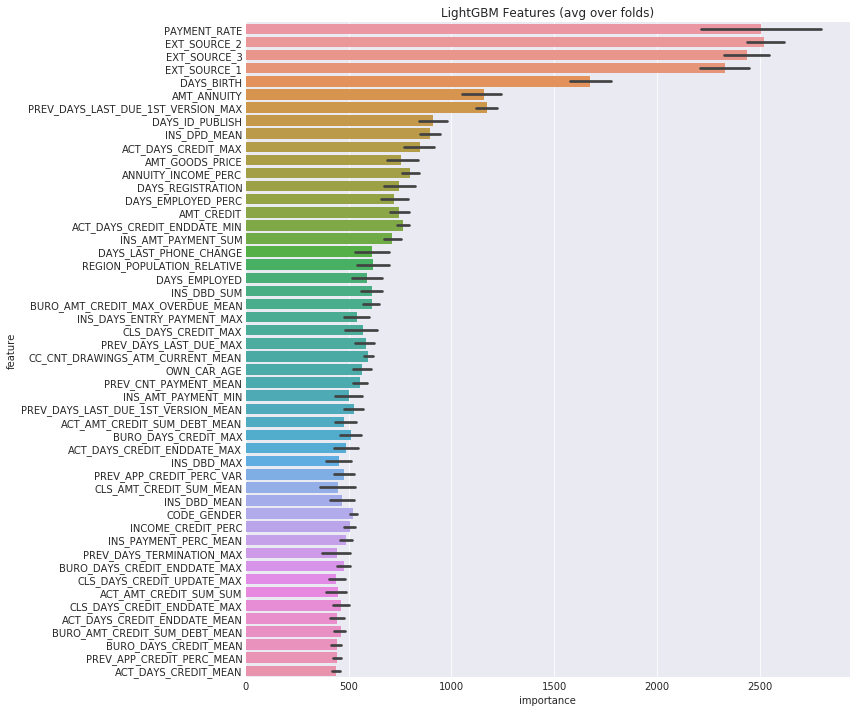

In [21]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[0:50].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-01.png')

In [4]:
folds = KFold(n_splits=5, shuffle=True, random_state=1700)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in data.columns if f not in exclude_fea]

NameError: name 'data' is not defined

In [7]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.9338690,
        subsample=0.97291513,
        max_depth=8,
        reg_alpha=0.06663684,
        reg_lambda=0.0988343,
        min_split_gain=0.07916152,
        min_child_weight=82.8850799,
        random_state=1700,
    )
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.742456	valid_1's auc: 0.730498
[200]	training's auc: 0.752584	valid_1's auc: 0.738657
[300]	training's auc: 0.767497	valid_1's auc: 0.750713
[400]	training's auc: 0.782488	valid_1's auc: 0.761905
[500]	training's auc: 0.793627	valid_1's auc: 0.769675
[600]	training's auc: 0.801849	valid_1's auc: 0.775303
[700]	training's auc: 0.808459	valid_1's auc: 0.779347
[800]	training's auc: 0.81397	valid_1's auc: 0.782101
[900]	training's auc: 0.818643	valid_1's auc: 0.784121
[1000]	training's auc: 0.822874	valid_1's auc: 0.78557
[1100]	training's auc: 0.826677	valid_1's auc: 0.786632
[1200]	training's auc: 0.830162	valid_1's auc: 0.787509
[1300]	training's auc: 0.833395	valid_1's auc: 0.788357
[1400]	training's auc: 0.836396	valid_1's auc: 0.788977
[1500]	training's auc: 0.83915	valid_1's auc: 0.789587
[1600]	training's auc: 0.841901	valid_1's auc: 0.790134
[1700]	training's auc: 0.844538	valid_1's auc: 0.7905

[400]	training's auc: 0.781889	valid_1's auc: 0.766586
[500]	training's auc: 0.793294	valid_1's auc: 0.774712
[600]	training's auc: 0.801658	valid_1's auc: 0.779703
[700]	training's auc: 0.808325	valid_1's auc: 0.78306
[800]	training's auc: 0.813775	valid_1's auc: 0.785441
[900]	training's auc: 0.818448	valid_1's auc: 0.787259
[1000]	training's auc: 0.8225	valid_1's auc: 0.788523
[1100]	training's auc: 0.826136	valid_1's auc: 0.789334
[1200]	training's auc: 0.82957	valid_1's auc: 0.790172
[1300]	training's auc: 0.832552	valid_1's auc: 0.790875
[1400]	training's auc: 0.835523	valid_1's auc: 0.791283
[1500]	training's auc: 0.838473	valid_1's auc: 0.791689
[1600]	training's auc: 0.841202	valid_1's auc: 0.792049
[1700]	training's auc: 0.843738	valid_1's auc: 0.792379
[1800]	training's auc: 0.846382	valid_1's auc: 0.792674
[1900]	training's auc: 0.848936	valid_1's auc: 0.792949
[2000]	training's auc: 0.851345	valid_1's auc: 0.793263
[2100]	training's auc: 0.853715	valid_1's auc: 0.793613
[2

In [4]:
folds = KFold(n_splits=5, shuffle=True, random_state=1700)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in data.columns if f not in exclude_fea]

In [5]:
len(feats)

938

In [7]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.9338690,
        subsample=0.97291513,
        max_depth=8,
        reg_alpha=0.06663684,
        reg_lambda=0.0988343,
        min_split_gain=0.07916152,
        min_child_weight=82.8850799,
        random_state=1700,
    )
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.742456	valid_1's auc: 0.730498
[200]	training's auc: 0.752584	valid_1's auc: 0.738657
[300]	training's auc: 0.767497	valid_1's auc: 0.750713
[400]	training's auc: 0.782488	valid_1's auc: 0.761905
[500]	training's auc: 0.793627	valid_1's auc: 0.769675


KeyboardInterrupt: 

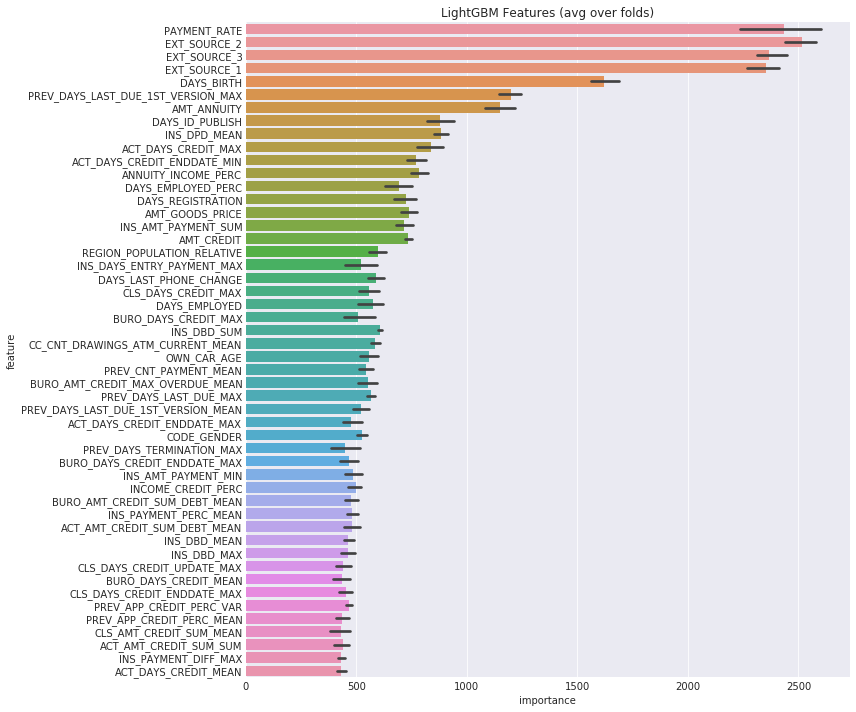

In [12]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[0:50].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances-01.png')